...

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [7]:
import cartopy.feature as cf 

In [50]:
import geopandas

In [121]:
from bokeh.plotting import figure, show 
from ipywidgets import interact
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## to do
* Want to subset the spatial data so only plots over the US (not ocean etc)
* Maybe want to have a contourplot, the dots are most honest though 

In [2]:
#date = '2020-12'
#df = pd.read_csv('{} temperature.csv'.format(date))
data_folder = 'Data'
filename = '2020-12 temperature.csv'
file = os.path.join(data_folder, filename)

#df = pd.read_csv('12-2020 temp and wind.csv')
df = pd.read_csv(file)

#df['average_temp'][(df['lat']>= 25) & (df['lat']<=26) & (df['lon']>= -80.9) & (df['lon']<= -80)]


71     297.19104
72     299.13340
165    295.43650
166    298.33066
259    295.28880
260    297.60318
Name: average_temp, dtype: float64

In [69]:
gdf = geopandas.GeoDataFrame(df, 
                             geometry=geopandas.points_from_xy(df['lon'], df['lat']),
                             crs = 'epsg:4269') #crs for North America

In [97]:
gdf.columns

Index(['Unnamed: 0', 'lat', 'lon', 'average_temp', 'average_min_daily_temp',
       'min_min_daily_temp', 'geometry'],
      dtype='object')

In [132]:
#from https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
#can also get school districts here!
state_file = os.path.join(data_folder, 'cb_2019_us_state_20m/cb_2019_us_state_20m.shp')
state = geopandas.read_file(state_file)

In [133]:
#https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql
state_abres = ['AK', 'PR', 'HI']
contenental_states = state[~state['STUSPS'].isin(state_abres)]
#state_test.head()

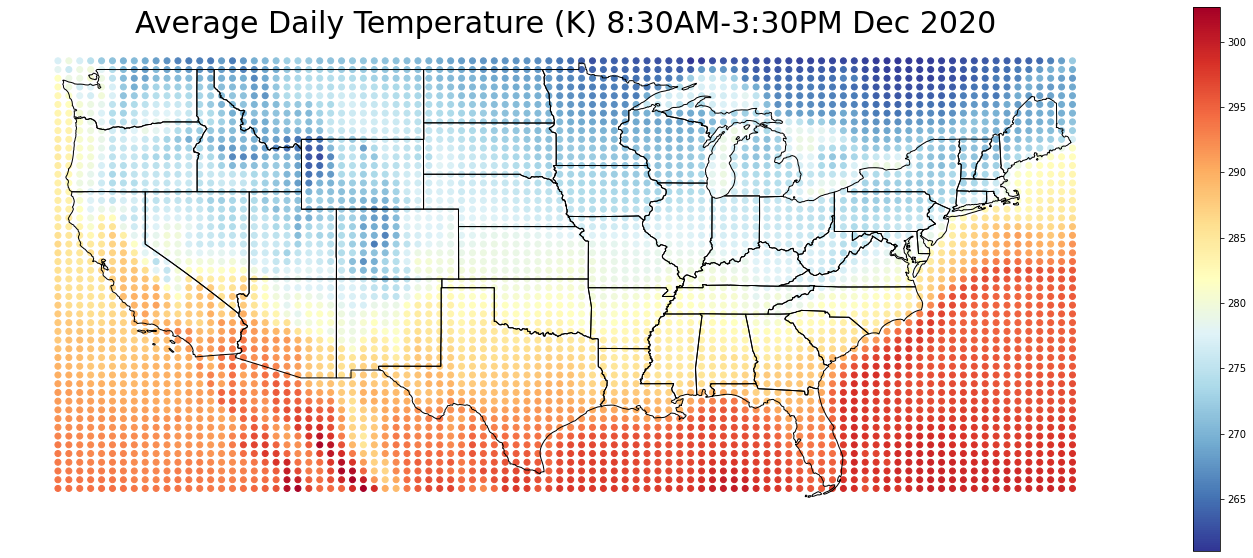

In [134]:
fig, ax = plt.subplots(figsize=(25,10))
#contenental_states.plot(ax=ax, color = 'none', edgecolor='black')
gdf.plot(ax=ax, column = 'average_temp', cmap = 'RdYlBu_r', legend=True)
contenental_states.plot(ax=ax, color = 'none', edgecolor='black')


ax.axis('off')
ax.set_title('Average Daily Temperature (K) 8:30AM-3:30PM Dec 2020',
            size=30);

## School District
-Ok not many are here! -looking at Elementary school dists

In [143]:
elementary_file = os.path.join(data_folder, 'cb_2019_us_elsd_500k/cb_2019_us_elsd_500k.shp')
elementary_dist = geopandas.read_file(elementary_file)

In [146]:
unified_file = os.path.join(data_folder, 'cb_2019_us_unsd_500k/cb_2019_us_unsd_500k.shp')
unified_dist = geopandas.read_file(unified_file)

In [150]:
unified_dist['STATEFP'].head()

0    42
1    27
2    29
3    01
4    17
Name: STATEFP, dtype: object

In [151]:
state_fips = ['02', '15', '60', '66', '69', '72', '78']
contenental_unified_dist = unified_dist[~unified_dist['STATEFP'].isin(state_fips)]
#state_test.head()

In [141]:
gdf.crs

'epsg:4269'

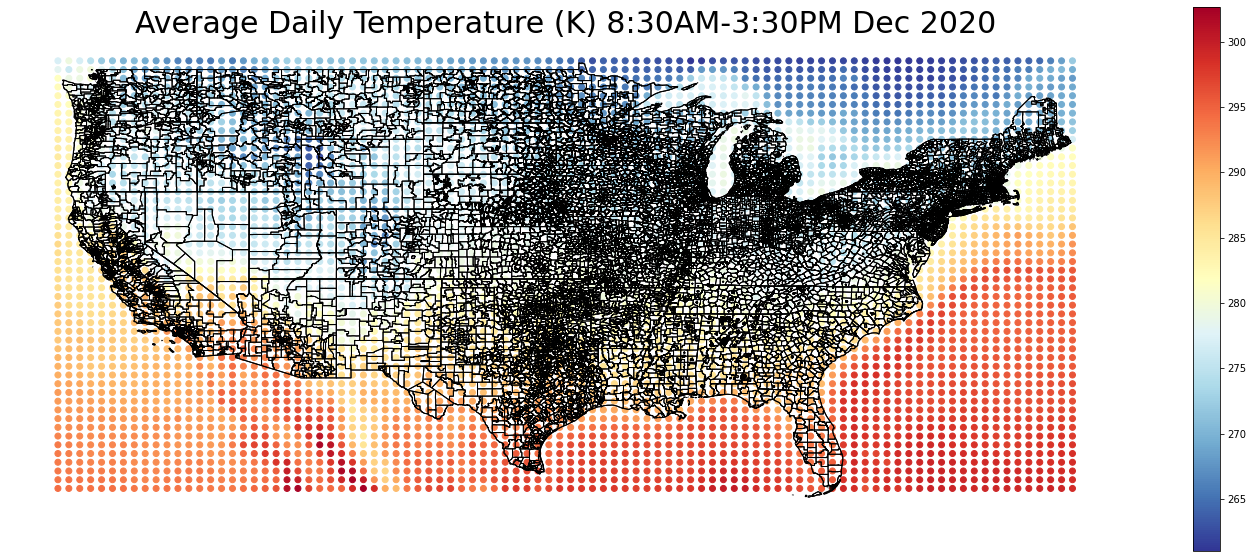

In [153]:
fig, ax = plt.subplots(figsize=(25,10))
#contenental_states.plot(ax=ax, color = 'none', edgecolor='black')
gdf.plot(ax=ax, column = 'average_temp', cmap = 'RdYlBu_r', legend=True)
elementary_dist.plot(ax=ax, color = 'none', edgecolor='black')
contenental_unified_dist.plot(ax=ax, color = 'none', edgecolor='black')
contenental_states.plot(ax=ax, color = 'none', edgecolor='black')



ax.axis('off')
ax.set_title('Average Daily Temperature (K) 8:30AM-3:30PM Dec 2020',
            size=30);

## Try interactive

In [159]:
plot = figure()
plot.circle(gdf['lon'], gdf['lat'], color = gdf['average_temp'])#, cmap = 'RdYlBu_r')#, legend=True)
show(plot)

## Origional -contourform

In [3]:
#https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
df_pivoted = df.pivot(index = 'lat', columns = 'lon', values = 'average_temp')
df_pivoted.columns
X=df_pivoted.columns#.levels[1].values
Y=df_pivoted.index.values
Z=df_pivoted.values
lon,lat = np.meshgrid(X, Y)


/Users/Sarah/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:385: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


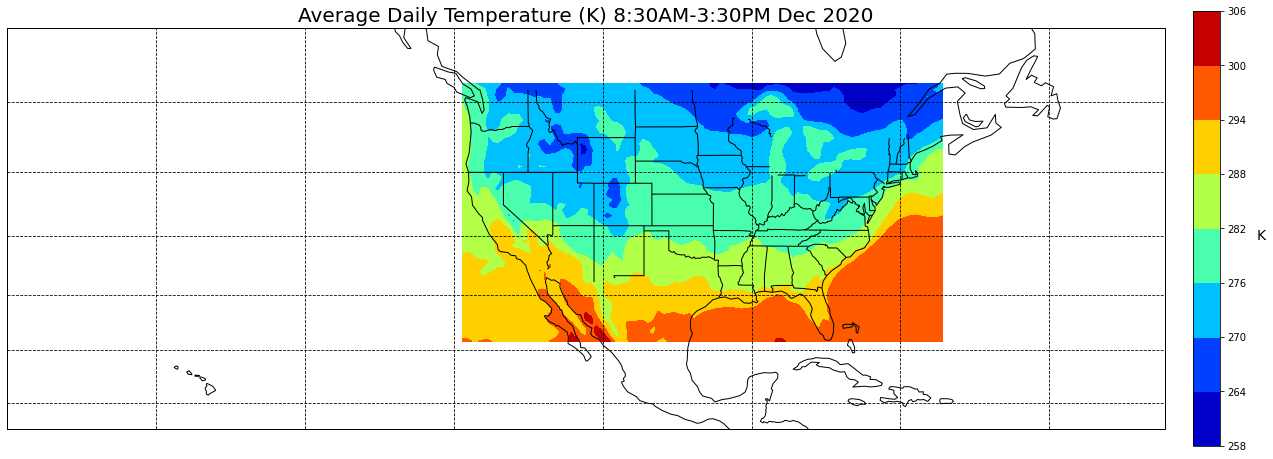

In [100]:
fig = plt.figure(figsize=(25,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([-400,-180,25,375])
    #ax.set_global()
    #ax.coastlines(resolution="50m",linewidth=1)
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black')
ax.add_feature(cf.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines',"110m",
    edgecolor='black', facecolor='none'))


plt.contourf(lon, lat, Z, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('Average Daily Temperature (K) 8:30AM-3:30PM Dec 2020', size=20)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('K',size=14,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=10)
plt.show()